In [1]:
! sud

/bin/sh: 1: sud: not found


In [2]:
import tensorflow as tf
import tensorflow_probability as tfp

import numpy as np
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [118]:
PERIODS= 100
TRANSACTION_COST = 0.01
HIST = 25

In [58]:
def noise(p=1,alpha=0.90):
    while True:
        yield alpha*p+(1-alpha)*np.random.normal(0,0.1)
n = noise()
P = [next(n) for x in range(1000)]
P = pd.Series(P)
P = np.exp(P / (P.max()-P.min()))

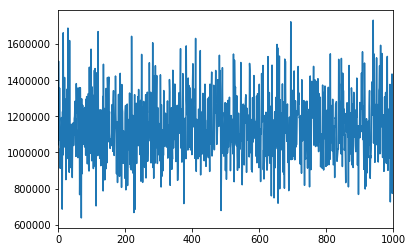

In [5]:
P.plot()

In [80]:
class SinEnv():
    def __init__(self):
        self.prices = []
        self.current_price =1
        self.transaction_costs =[]
        self.returns=[]
        self.last_transaction_cost =0
        self.positions =[]
        self.position =0
        self.cash =100
        self.period = 0
        self.ret = 0
        self.returns = []
        self.market_return =0
        self.market_returns =[]
    def nextPrice(self):
        self.prices.append(self.current_price)
        self.period+=1
        self.current_price=  max(np.sin(((self.period+np.random.uniform(-0.002,0.002)))*np.pi/PERIODS)+1.01,0.1)
    
    def updatePosition(self,diff):
        self.transaction_costs.append(self.last_transaction_cost)
        self.positions.append(self.position)
        
        self.last_transaction_cost = np.abs(TRANSACTION_COST*diff*self.current_price)
        self.position = np.clip(self.position+diff,-0.9999,0.9999)
    
    def step(self,newPosition):
        self.nextPrice()
        self.updatePosition(newPosition)
        self.market_returns.append(self.market_return)
        self.returns.append(self.ret)
        
        self.market_return = np.log(self.current_price / self.prices[-1]) 
        self.ret = self.position*self.market_return - self.last_transaction_cost
        nextState = [p for p in self.prices[-1*HIST:]]
        nextState.append(self.current_price)
        nextState.append(self.position)
        return nextState,self.ret,False
    
    
        
    
    

In [81]:
[1,2,3,4,5][-3:]

[3, 4, 5]

In [82]:
S = SinEnv()
for i in range(1000):
    newPos = 0
    if S.current_price >1 and S.current_price > S.prices[-1] :
        newPos =1
    elif S.current_price <1 and S.current_price <S.prices[-1]:
        newPos =-1
    
    S.step(newPos)

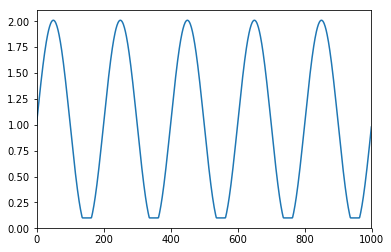

In [83]:
pd.Series(S.prices).plot()

In [84]:
class ValueEstimator():
    """
    Policy Function approximator. 
    """
    
    def __init__(self, learning_rate=0.01, scope="value_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.float32, [HIST+2], "state") #HIST prices, current, and position
            self.target = tf.placeholder(dtype=tf.float32, name="target") #Position size

            # This is just linear classifier
            inp = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(self.state, 0),
                num_outputs=16,
                activation_fn=tf.nn.relu,
                weights_initializer=tf.initializers.glorot_uniform)
            inp = tf.contrib.layers.layer_norm(inp)
            
            self.mu = tf.contrib.layers.fully_connected(
                inputs=inp,
                num_outputs=1,
                activation_fn=tf.nn.tanh,
                weights_initializer=tf.initializers.glorot_uniform)
            self.mu = tf.squeeze(self.mu)
            
            self.value_estimate = tf.squeeze(self.mu)
            self.loss = tf.squared_difference(self.value_estimate, self.target)

            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())        
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        
        return sess.run(self.value_estimate, { self.state: state })

    def update(self, state, target, sess=None):
        sess = sess or tf.get_default_session()
        
        feed_dict = { self.state: state, self.target: target }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss


In [1]:
class PolicyEstimator():
    """
    Policy Function approximator. 
    """
    
    def __init__(self, learning_rate=0.01, scope="policy_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.float32, [HIST+2], "state") #HIST prices, current, and position
            self.target = tf.placeholder(dtype=tf.float32, name="target") #Position size

            # This is just linear classifier
            inp = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(self.state, 0),
                num_outputs=16,
                activation_fn=tf.nn.relu,
                weights_initializer=tf.initializers.glorot_uniform)
            inp = tf.contrib.layers.layer_norm(inp)
            
            self.mu = tf.contrib.layers.fully_connected(
                inputs=inp,
                num_outputs=1,
                activation_fn=tf.nn.tanh,
                weights_initializer=tf.initializers.glorot_uniform)
            self.mu = tf.squeeze(self.mu)
            
            self.sigma = tf.contrib.layers.fully_connected(
                inputs=inp,
                num_outputs=1,
                activation_fn=tf.nn.relu,
                weights_initializer=tf.initializers.glorot_uniform)
            
            self.sigma = tf.nn.softplus(tf.squeeze(self.sigma))+0.00001
            
            self.normal_dist = tfp.distributions.TruncatedNormal(self.mu, self.sigma,-1,1)
            self.action = self.normal_dist._sample_n(1)
            

            # Loss and train op
            self.loss = -self.normal_dist.log_prob(self.action) * self.target
            # Add cross entropy cost to encourage exploration
            self.loss -= 1e-1 * self.normal_dist.entropy() 
            
            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        return sess.run([self.action,self.mu,self.sigma], { self.state: state })

    def update(self, state, target, action, sess=None):
        sess = sess or tf.get_default_session()
        feed_dict = { self.state: state, self.target: target, self.action: action  }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [111]:
import collections
import itertools
def reinforce(estimator_policy,estimator_value,  num_episodes, discount_factor=1.0,length=1000):
    
    """
    REINFORCE (Monte Carlo Policy Gradient) Algorithm. Optimizes the policy
    function approximator using policy gradient.
    
    Args:
        env: OpenAI environment.
        estimator_policy: Policy Function to be optimized 
        estimator_value: Value function approximator, used as a baseline
        num_episodes: Number of episodes to run for
        discount_factor: Time-discount factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    
    Transition = collections.namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
    
    for i_episode in range(num_episodes):
        # Reset the environment and pick the fisrst action
        env = SinEnv()
        [env.step(0) for i in range(HIST)]
        episode = []
        state,reward,done = env.step(0)
        
        # One step in the environment
        for t in itertools.count():
            
            # Take a step
            action,mu,sigma = estimator_policy.predict(state)
            next_state, reward, done  = env.step(action[0])
            
            # Keep track of the transition
            episode.append(Transition(
              state=state, action=action, reward=reward, next_state=next_state, done=done))
            
           
                       # Calculate TD Target
            value_next = estimator_value.predict(next_state)
            td_target = reward + discount_factor * value_next
            td_error = td_target - estimator_value.predict(state)
            
            # Update the value estimator
            estimator_value.update(state, td_target)
            
            # Update the policy estimator
            # using the td error as our advantage estimate
            estimator_policy.update(state, td_error, action)
            
            # Print out which step we're on, useful for debugging.
            print("\rStep {} @ Episode {}/{}, {} - {} - {} ".format(
                    t, i_episode + 1, num_episodes,action, mu,sigma ), end="")
            
            if t > length:
                break
                
            state = next_state
    
#         # Go through the episode and make policy updates
#         for t, transition in enumerate(episode):
#             # The return after this timestep
#             rew = np.fromiter((discount_factor**i * t.reward for i, t in enumerate(episode[t:])),dtype=np.float32)
#             total_return = sum(rew)
#             # Calculate baseline/advantage
#             baseline_value = 0
#             advantage = total_return - baseline_value
            
#             # Update our policy estimator
#             try:
#                 estimator_policy.update(transition.state, advantage, transition.action)
#             except:
#                 raise Exception(transition)
    
    return env


In [106]:
sum

<function numpy.core.fromnumeric.sum>

In [129]:
tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)
policy_estimator = PolicyEstimator(learning_rate=0.001)
value_estimator = ValueEstimator(learning_rate=0.001)


with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    
    # Note, due to randomness in the policy the number of episodes you need varies
    # TODO: Sometimes the algorithm gets stuck, I'm not sure what exactly is happening there.
    S = reinforce( policy_estimator,value_estimator,  
                  5000, discount_factor=0.01,length=600)


Step 601 @ Episode 5000/5000, [0.6390147] - 0.020030781626701355 - 1.7426621913909912       

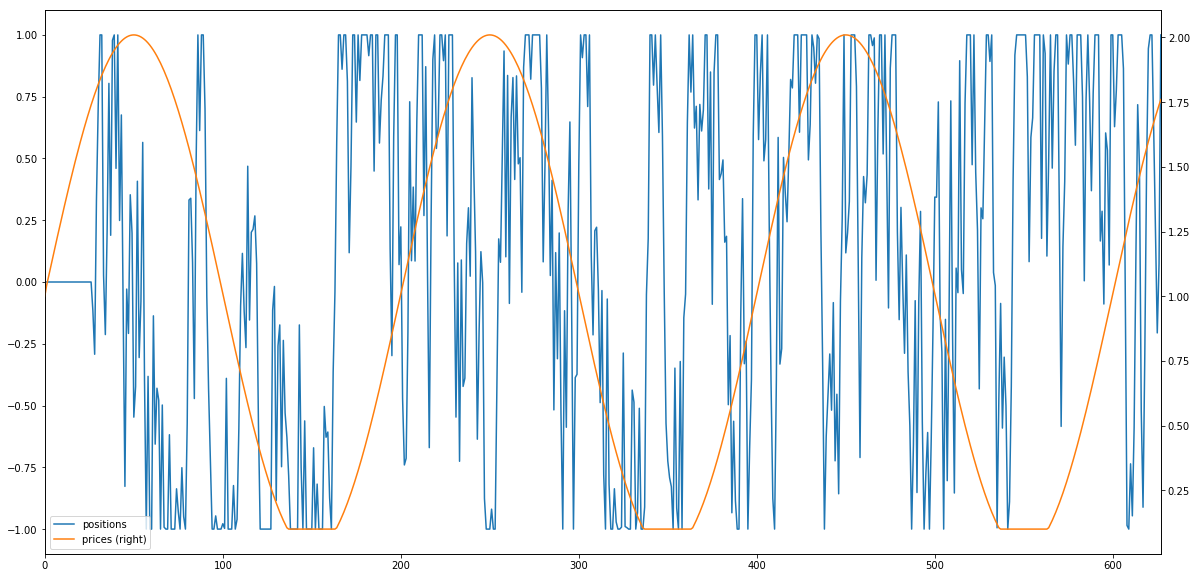

In [132]:
d = {"prices":S.prices,"returns":S.returns,"costs":S.transaction_costs,"positions":S.positions}
D = pd.DataFrame(d)
D[['positions','prices',]].plot(secondary_y='prices',figsize=(20,10))

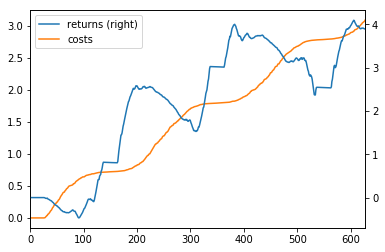

In [131]:
D[['returns','costs',]].cumsum().plot(secondary_y='returns')

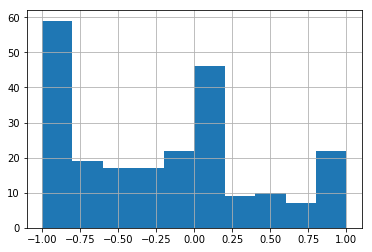

In [45]:
D.positions.hist()

In [ ]:
D[['sh','returns']].corr()